In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

dataset_dir = '/content/drive/MyDrive/flowers-recognition'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='categorical')

vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False

def extract_features(generator):
    features = []
    labels = []
    for _ in range(generator.samples // generator.batch_size):
        imgs, lbls = next(generator)
        feature = vgg_model.predict(imgs)
        feature = feature.reshape(feature.shape[0], -1)
        features.append(feature)
        labels.append(lbls)

    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

train_features, train_labels = extract_features(train_generator)
test_features, test_labels = extract_features(test_generator)

train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, n_jobs=-1, scoring='accuracy')
rf_grid.fit(train_features, train_labels)

svm_grid = GridSearchCV(SVC(), svm_params, cv=3, n_jobs=-1, scoring='accuracy')
svm_grid.fit(train_features, train_labels)

best_rf_model = rf_grid.best_estimator_
best_svm_model = svm_grid.best_estimator_

rf_best_pred = best_rf_model.predict(test_features)
svm_best_pred = best_svm_model.predict(test_features)

rf_best_accuracy = accuracy_score(test_labels, rf_best_pred)
svm_best_accuracy = accuracy_score(test_labels, svm_best_pred)

print(f"Оптимальная точность Random Forest: {rf_best_accuracy:.4f}")
print(f"Оптимальная точность SVM: {svm_best_accuracy:.4f}")
print("Лучшие гиперпараметры Random Forest:", rf_grid.best_params_)
print("Лучшие гиперпараметры SVM:", svm_grid.best_params_)


Found 200 images belonging to 6 classes.
Found 52 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Оптимальная точность Random Forest: 0.6250
Оптимальная точность SVM: 0.5938
Лучшие гиперпараметры Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Лучшие гиперпараметры SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


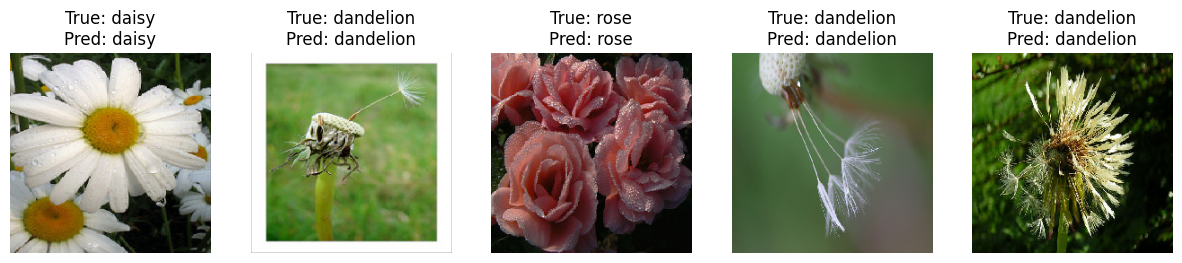

In [8]:
import matplotlib.pyplot as plt

def visualize_predictions(generator, model, n_samples=5, use_features=True):

    imgs, lbls = next(generator)

    if use_features:

        features = vgg_model.predict(imgs)
        features = features.reshape(features.shape[0], -1)
        preds = model.predict(features)
    else:
        preds = model.predict(imgs)
        preds = np.argmax(preds, axis=1)

    true_labels = np.argmax(lbls, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

# Визуализация предсказаний для SVM
visualize_predictions(test_generator, best_svm_model, use_features=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


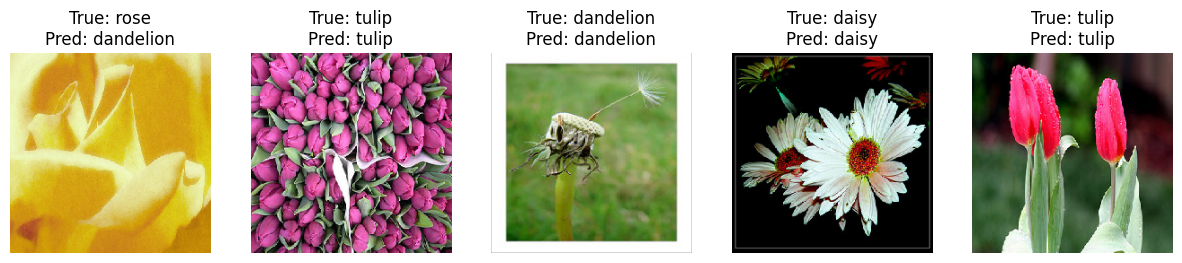

In [15]:
import matplotlib.pyplot as plt

def visualize_predictions_rf(generator, model, n_samples=5):

    imgs, lbls = next(generator)

    features = vgg_model.predict(imgs)
    features = features.reshape(features.shape[0], -1)

    preds = model.predict(features)

    true_labels = np.argmax(lbls, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(imgs[i])
        plt.title(f"True: {list(generator.class_indices.keys())[true_labels[i]]}\n"
                  f"Pred: {list(generator.class_indices.keys())[preds[i]]}")
        plt.axis('off')
    plt.show()

# Визуализация предсказаний для Random Forest
visualize_predictions_rf(test_generator, best_rf_model)
